<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/deeplearningstudy/blob/main/ch17_GAN%EA%B3%BCAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 17장 세상에 없는 얼굴 GAN, 오토인코더

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. 적대적 신경망 실행하기

### 실습: GAN 모델 만들기
##### (실행 시간이 오래 걸립니다. 런타임 유형을 T4 GPU로 바꾸어 실행하시기를 권합니다.)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 28, 28, 1)      │       865,281 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 1)              │       212,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,078,146 (4.11 MB)

 Trainable params: 852,609 (3.25 MB)

 Non-trainable params: 225,537 (881.00 KB)

epoch:0  d_loss:0.6761  g_loss:0.6434


epoch:100  d_loss:0.4087  g_loss:0.3538
epoch:200  d_loss:0.3955  g_loss:0.4283
epoch:300  d_loss:0.5051  g_loss:0.5694
epoch:400  d_loss:0.5674  g_loss:0.6349
epoch:500  d_loss:0.5977  g_loss:0.6722
epoch:600  d_loss:0.6132  g_loss:0.6997
epoch:700  d_loss:0.6204  g_loss:0.7204
epoch:800  d_loss:0.6238  g_loss:0.7388
epoch:900  d_loss:0.6260  g_loss:0.7527
epoch:1000  d_loss:0.6327  g_loss:0.7552
epoch:1100  d_loss:0.6387  g_loss:0.7549
epoch:1200  d_loss:0.6425  g_loss:0.7592
epoch:1300  d_loss:0.6455  g_loss:0.7629
epoch:1400  d_loss:0.6479  g_loss:0.7658
epoch:1500  d_loss:0.6499  g_loss:0.7683
epoch:1600  d_loss:0.6518  g_loss:0.7702
epoch:1700  d_loss:0.6534  g_loss:0.7720
epoch:1800  d_loss:0.6550  g_loss:0.7734
epoch:1900  d_loss:0.6563  g_loss:0.7742
epoch:2000  d_loss:0.6575  g_loss:0.7748
epoch:2100  d_loss:0.6585  g_loss:0.7758
epoch:2200  d_loss:0.6594  g_loss:0.7765
epoch:2300  d_loss:0.6599  g_loss:0.7778
epoch:2400  d_loss:0.6607  g_loss:0.7783
epoch:2500  d_loss:0.6614

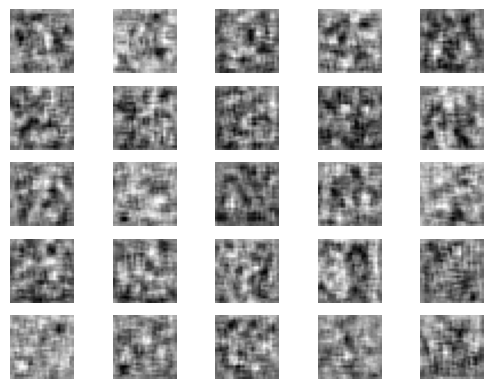

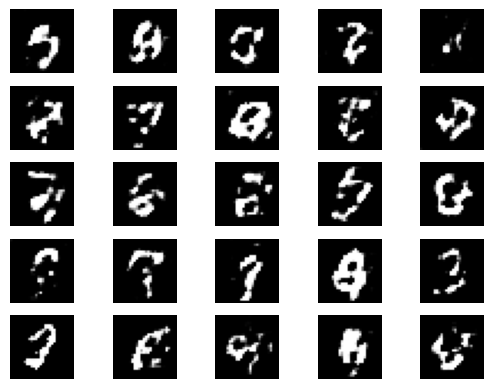

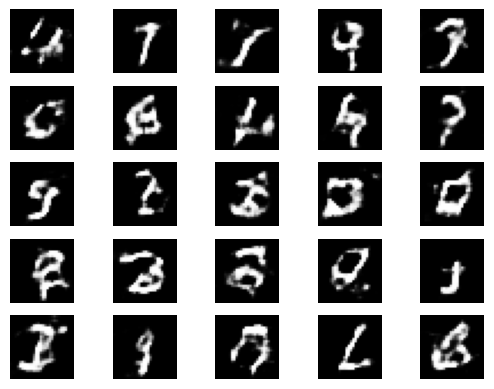

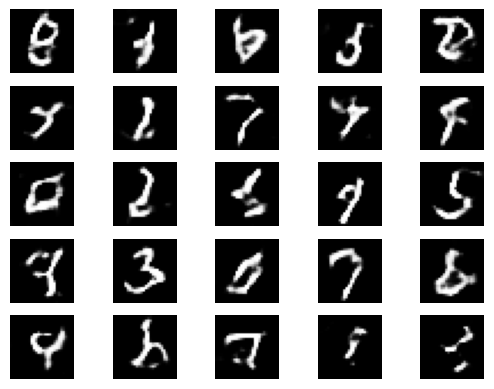

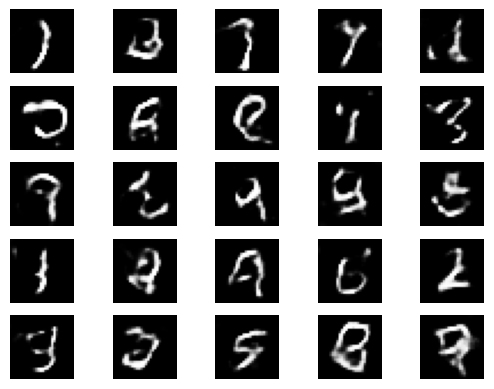

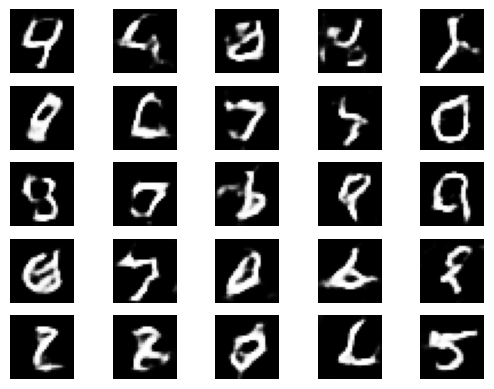

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os
os.makedirs("/content/drive/MyDrive/kdt_2506/모두의딥러닝/data/gan_images", exist_ok=True)

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])   #  beta_1은 Adam의 모멘텀계수, 0.9가 디폴트이나 0.5가 더 좋다고 함(불안정발산 방지).
discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

gan.summary()

# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):

          ########## 판별자 학습 시작 ##########
          discriminator.trainable = True

          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size) # batch_size만큼의 random idx 추출(0에서 X_train.shape[0]구간)
          imgs = X_train[idx] # random idx 이미지를 추출
          d_loss_real = discriminator.train_on_batch(imgs, true) # 이 이미지를 true(1로된 array)라고 지정하고 학습시킴.

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100)) # batch_size만큼의 0에서 1사이 100차원짜리 noise vector 생성
          gen_imgs = generator.predict(noise, verbose=0) # 이 노이즈를 기초로 가짜 이미지 생성. generator.predict에 주의
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # 가짜를 가짜라고(0으로 된 array) 지정하고 학습시킴.

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 진짜를 진짜라고 한 것과 가짜를 가짜라고 한 loss를 평균냄.
          discriminator.trainable = False
          ########## 판별자 학습 종료 ##########

          ########## 생성자 학습 시작 ##########
          noise = np.random.normal(0, 1, (batch_size, 100))
          g_loss = gan.train_on_batch(noise, true) # gan.train_on_batch가 gan.fit과 같은 의미
          ########## 생성자 학습 종료 ##########

          if i % 100 == 0:
            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss[0], ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise, verbose=0)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("/content/drive/MyDrive/kdt_2506/모두의딥러닝/data/gan_images_epoch_%d.png" % i)

gan_train(4001, 32, 800)  # 4000번 반복되고, 배치 사이즈는 32,  800번마다 결과가 저장되게 하였습니다.


## 4. 이미지의 특징을 추출하는 오토인코더

### 실습: 오토인코더 실습하기

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분입니다.
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인합니다.
autoencoder.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.3236 - val_loss: 0.1367
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1312 - val_loss: 0.1187
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1169 - val_loss: 0.1099
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1099 - val_loss: 0.1059
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1054 - val_loss: 0.1023
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1024 - val_loss: 0.0992
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1001 - val_loss: 0.0982
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0985 - val_loss: 0.0964
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0974 - val_loss: 0.0950
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0962 - val_loss: 0.0941
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0952 - val_loss: 0.0935
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

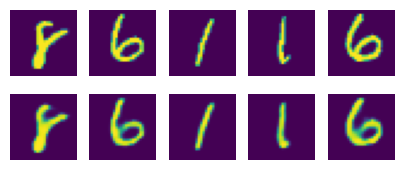

In [ ]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test)) #[허] (X_test, X_test) 둘다 X_test임.

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):        # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1)
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28))  # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()